# RAVDESS Emotion Recognition: Dimensionality Reduction

This notebook explores dimensionality reduction techniques combined with Optuna hyperparameter tuning to optimize model performance across different feature spaces.

**Techniques:**
- PCA (Principal Component Analysis) - Unsupervised
- LDA (Linear Discriminant Analysis) - Supervised
- PCA+LDA - Hybrid approach

**Models:**
- Random Forest with Optuna tuning
- Gradient Boosting with Optuna tuning

**Dataset:** 1,440 samples × 90,004 features → 8 emotion classes

## Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [28]:
dataset = pd.read_csv("../data/ABT_1_ravdess.csv")

In [29]:
display(dataset.head())
print(f"Dataset shape: {dataset.shape}")

,modality,vocal_channel,intensity,statement,repetition,actor,emotion,gender,loudness_db,y_0,...,y_89986,y_89987,y_89988,y_89989,y_89990,y_89991,y_89992,y_89993,y_89994,y_89995
0,3,1,1,2,1,16,angry,Female,-64.729790,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1,1,2,2,16,fearful,Female,-65.943780,2.051093e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,2,1,2,16,fearful,Female,-51.392780,-8.404510e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,1,1,16,angry,Female,-59.114307,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1,1,1,1,16,disgust,Female,-69.102135,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dataset shape: (1440, 90005)


## Preprocessing

In [30]:
# Prepare target variable
y = dataset["emotion"].copy()

# Prepare features
target = "emotion"
X = dataset.copy().drop(columns=target)

# Encode gender column: Male = 1, Female = 0
X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Emotion classes: {y.unique()}")

Features shape: (1440, 90004)
Target shape: (1440,)
Emotion classes: ['angry' 'fearful' 'disgust' 'sad' 'surprised' 'happy' 'calm' 'neutral']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 1008
Test set size: 432
Number of features: 90004


## Feature Scaling

Both PCA and LDA require standardized features.

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Scaled training set shape: (1008, 90004)
Scaled test set shape: (432, 90004)


# Principal Component Analysis (PCA)

PCA is an unsupervised dimensionality reduction technique that:
- Finds directions of maximum variance in the data
- Projects data onto principal components
- Reduces dimensionality while preserving most variance

## Explained Variance Analysis

First, let's determine how many components we need to retain a certain percentage of variance.

In [33]:
# Fit PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative variance explained
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"Components needed for 99% variance: {n_components_99}")
print(f"\nOriginal number of features: {X_train_scaled.shape[1]}")

Components needed for 90% variance: 170
Components needed for 95% variance: 266
Components needed for 99% variance: 522

Original number of features: 90004


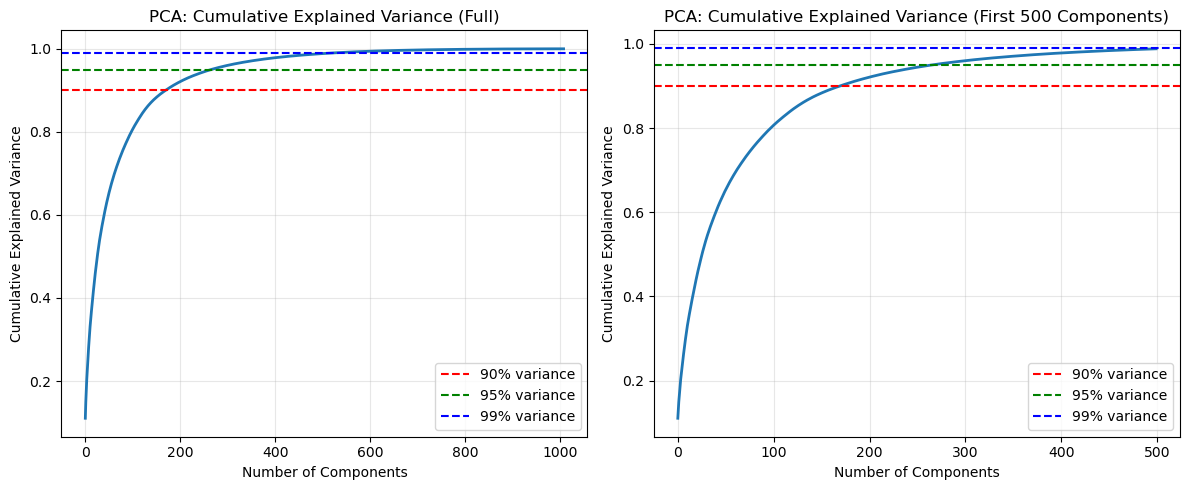

In [34]:
# Plot cumulative explained variance
plt.figure(figsize=(12, 5))

# Plot 1: Full view
plt.subplot(1, 2, 1)
plt.plot(cumsum_variance, linewidth=2)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance (Full)')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Zoomed view (first 500 components)
plt.subplot(1, 2, 2)
plt.plot(cumsum_variance[:500], linewidth=2)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance (First 500 Components)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/21_pca_cumulative_variance.png', dpi=300, bbox_inches='tight')

plt.show()

## Apply PCA with 95% Variance

We'll use PCA to retain 95% of the variance as a balance between dimensionality reduction and information preservation.

In [35]:
# Apply PCA with 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original dimensions: {X_train_scaled.shape[1]}")
print(f"Reduced dimensions (PCA): {X_train_pca.shape[1]}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {(1 - X_train_pca.shape[1]/X_train_scaled.shape[1])*100:.2f}%")

Original dimensions: 90004
Reduced dimensions (PCA): 266
Variance explained: 0.9501
Dimensionality reduction: 99.70%


## Visualize PCA Results

Plot the first 2 principal components to see how well emotions are separated.

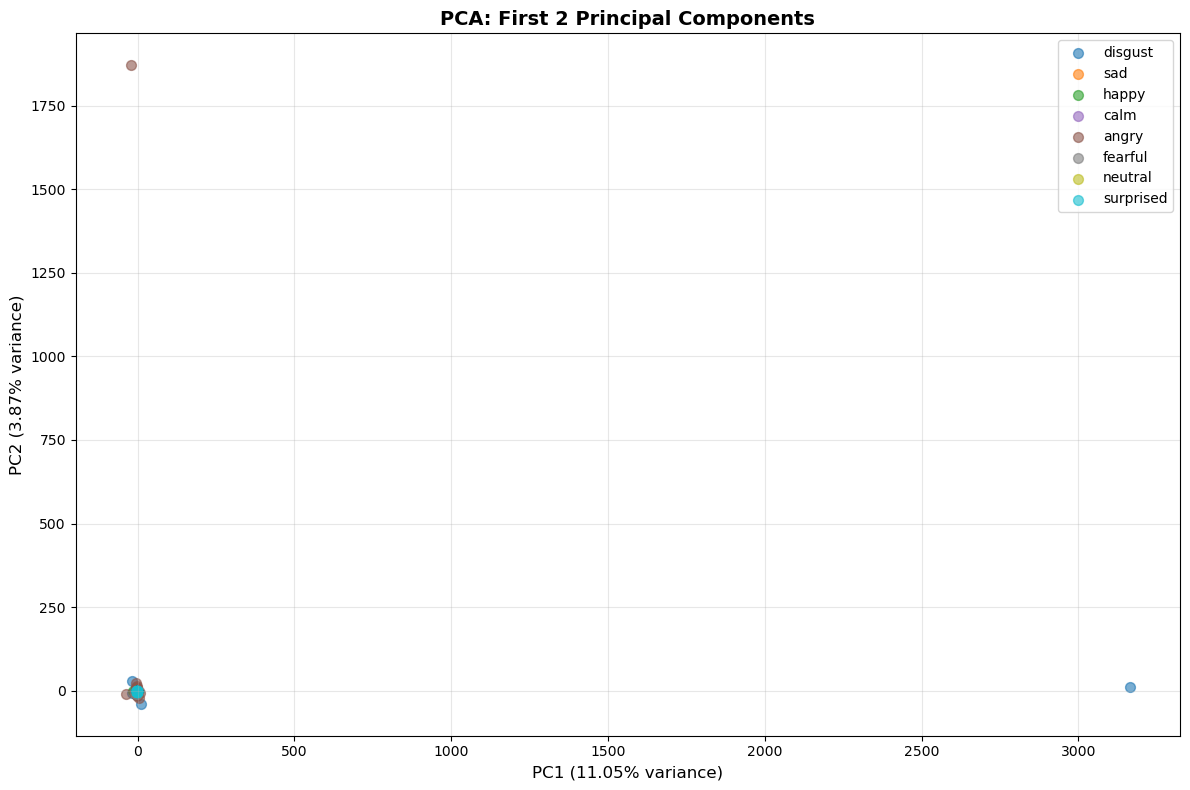

In [36]:
# Create a 2D visualization using first 2 principal components
plt.figure(figsize=(12, 8))

emotions = y_train.unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(emotions)))

for emotion, color in zip(emotions, colors):
    mask = y_train == emotion
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                c=[color], label=emotion, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA: First 2 Principal Components', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/22_pca_2d_visualization.png', dpi=300, bbox_inches='tight')

plt.show()

# Linear Discriminant Analysis (LDA)

LDA is a supervised dimensionality reduction technique that:
- Maximizes class separability
- Finds linear combinations that best separate classes
- Maximum components = min(n_features, n_classes - 1)

For 8 emotion classes, LDA can produce maximum 7 components.

In [37]:
# Apply LDA (max 7 components for 8 classes)
lda = LDA(n_components=7)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

print(f"Original dimensions: {X_train_scaled.shape[1]}")
print(f"Reduced dimensions (LDA): {X_train_lda.shape[1]}")
print(f"Variance explained: {lda.explained_variance_ratio_.sum():.4f}")
print(f"Dimensionality reduction: {(1 - X_train_lda.shape[1]/X_train_scaled.shape[1])*100:.2f}%")

Original dimensions: 90004
Reduced dimensions (LDA): 7
Variance explained: 1.0000
Dimensionality reduction: 99.99%


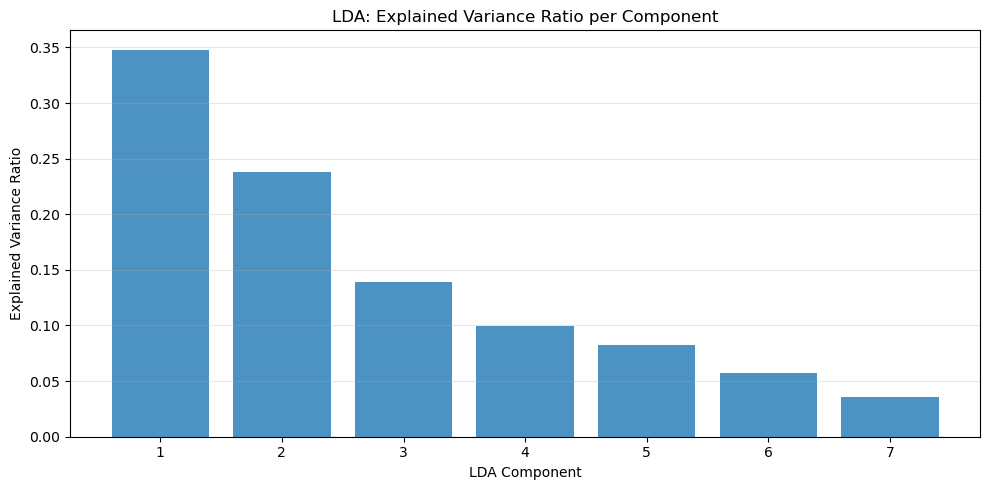

Variance explained by each LDA component:
  LD1: 0.3480
  LD2: 0.2378
  LD3: 0.1393
  LD4: 0.0992
  LD5: 0.0826
  LD6: 0.0570
  LD7: 0.0361


In [38]:
# Plot explained variance ratio for LDA components
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(lda.explained_variance_ratio_) + 1), 
        lda.explained_variance_ratio_, alpha=0.8)
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('LDA: Explained Variance Ratio per Component')
plt.xticks(range(1, len(lda.explained_variance_ratio_) + 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/23_lda_variance_per_component.png', dpi=300, bbox_inches='tight')

plt.show()

print("Variance explained by each LDA component:")
for i, var in enumerate(lda.explained_variance_ratio_, 1):
    print(f"  LD{i}: {var:.4f}")

## Visualize LDA Results

Plot the first 2 linear discriminants to see class separation.

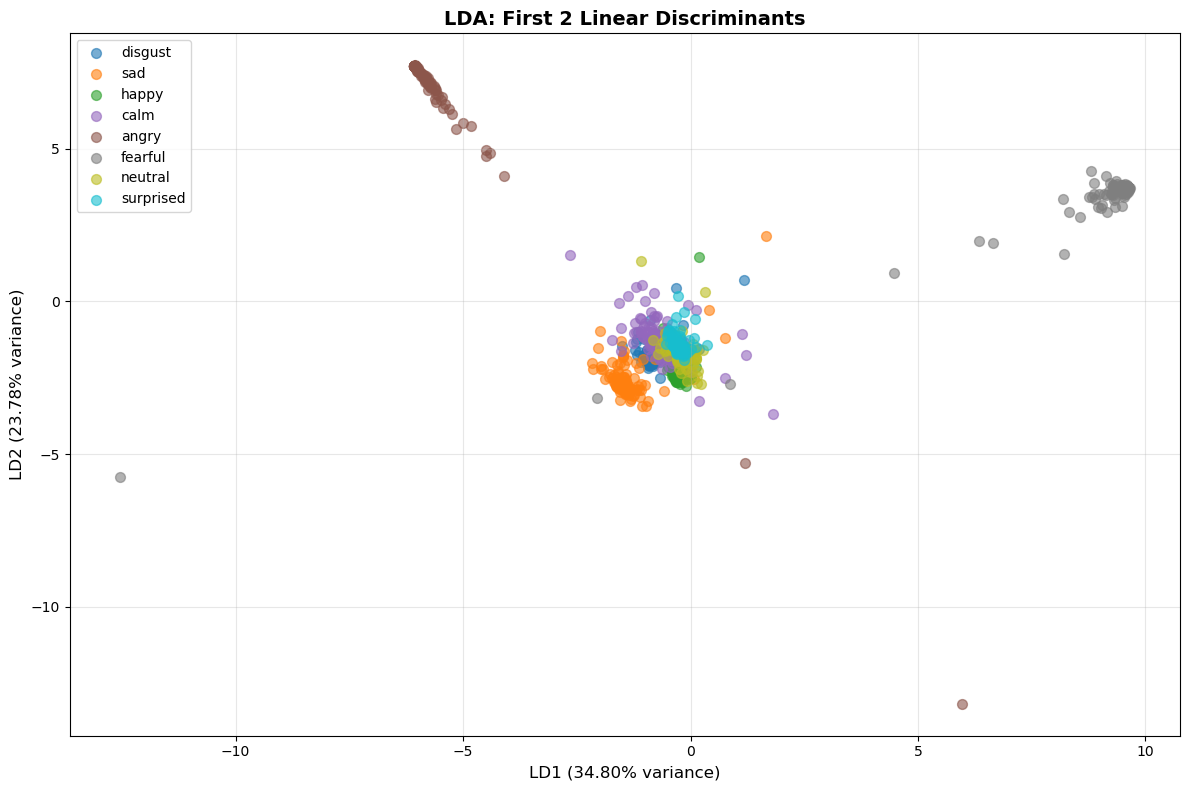

In [41]:
# Create a visualization using available linear discriminants
if X_train_lda.shape[1] >= 2:
    # 2D plot if we have at least 2 components
    plt.figure(figsize=(12, 8))
    
    emotions = y_train.unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(emotions)))
    
    for emotion, color in zip(emotions, colors):
        mask = y_train == emotion
        plt.scatter(X_train_lda[mask, 0], X_train_lda[mask, 1], 
                    c=[color], label=emotion, alpha=0.6, s=50)
    
    plt.xlabel(f'LD1 ({lda.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'LD2 ({lda.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.title('LDA: First 2 Linear Discriminants', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    import os
    os.makedirs('../output/EDA_plots', exist_ok=True)
    plt.savefig('../output/EDA_plots/25_lda_2d_visualization.png', dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    # 1D plot if we only have 1 component
    plt.figure(figsize=(12, 6))
    
    emotions = y_train.unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(emotions)))
    
    for emotion, color in zip(emotions, colors):
        mask = y_train == emotion
        y_jitter = np.random.normal(0, 0.02, size=mask.sum())
        plt.scatter(X_train_lda[mask, 0], y_jitter, 
                    c=[color], label=emotion, alpha=0.6, s=50)
    
    plt.xlabel(f'LD1 ({lda.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel('Random Jitter (for visualization)', fontsize=12)
    plt.title('LDA: Single Linear Discriminant', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    import os
    os.makedirs('../output/EDA_plots', exist_ok=True)
    plt.savefig('../output/EDA_plots/25_lda_1d_visualization.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"\nNote: LDA only produced {X_train_lda.shape[1]} component(s).")
    print("This suggests limited linear separability between emotion classes.")

## LDA Issue: Rank Deficiency

The LDA produced only 1 component instead of 7 due to rank deficiency. This happens when features >> samples (90,006 >> 1,008).

**Solution**: Apply PCA first to reduce dimensionality, then apply LDA.

This is a common approach called **PCA+LDA**.

In [40]:
# Apply PCA first (reduce to 300 components), then LDA
print("Applying PCA+LDA approach...")
print(f"Step 1: PCA to reduce 90,006 → 300 features")

pca_for_lda = PCA(n_components=300, random_state=42)
X_train_pca_for_lda = pca_for_lda.fit_transform(X_train_scaled)
X_test_pca_for_lda = pca_for_lda.transform(X_test_scaled)

print(f"  PCA variance retained: {pca_for_lda.explained_variance_ratio_.sum():.4f}")
print(f"\nStep 2: LDA on PCA-reduced features to get 7 components")

lda_after_pca = LDA(n_components=7)
X_train_pca_lda = lda_after_pca.fit_transform(X_train_pca_for_lda, y_train)
X_test_pca_lda = lda_after_pca.transform(X_test_pca_for_lda)

print(f"  Final dimensions: {X_train_pca_lda.shape[1]}")
print(f"  LDA variance explained: {lda_after_pca.explained_variance_ratio_.sum():.4f}")
print(f"\nFinal reduction: 90,006 → {X_train_pca_lda.shape[1]} features")

Applying PCA+LDA approach...
Step 1: PCA to reduce 90,006 → 300 features
  PCA variance retained: 0.9596

Step 2: LDA on PCA-reduced features to get 7 components
  Final dimensions: 7
  LDA variance explained: 1.0000

Final reduction: 90,006 → 7 features


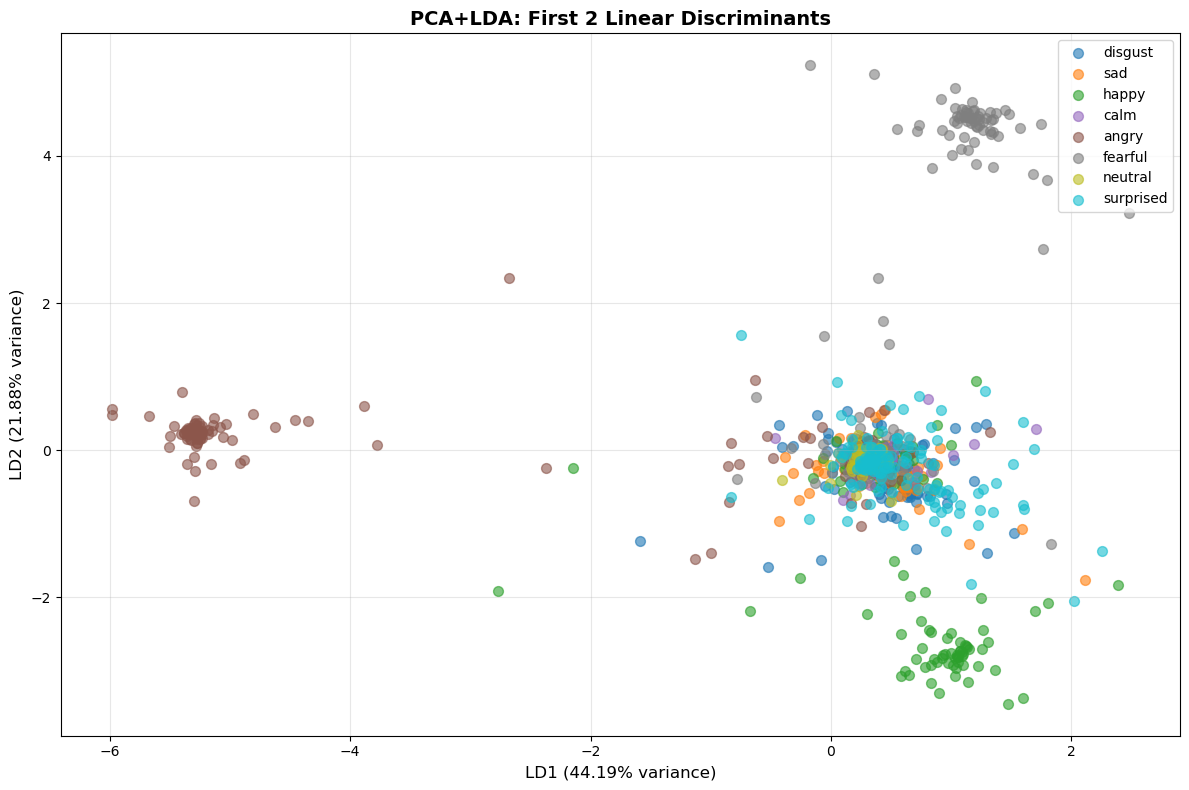

In [39]:
# Visualize PCA+LDA results
plt.figure(figsize=(12, 8))

emotions = y_train.unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(emotions)))

for emotion, color in zip(emotions, colors):
    mask = y_train == emotion
    plt.scatter(X_train_pca_lda[mask, 0], X_train_pca_lda[mask, 1], 
                c=[color], label=emotion, alpha=0.6, s=50)

plt.xlabel(f'LD1 ({lda_after_pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'LD2 ({lda_after_pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA+LDA: First 2 Linear Discriminants', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/24_pca_lda_2d_visualization.png', dpi=300, bbox_inches='tight')

plt.show()

# Model Comparison: Original vs PCA vs LDA vs PCA+LDA

Compare model performance using Optuna hyperparameter tuning on:
1. Original features (90,004 features)
2. PCA-reduced features (266 components, 95% variance)
3. LDA-reduced features (7 components)
4. PCA+LDA features (7 components after PCA preprocessing)

We'll use Random Forest and Gradient Boosting with Optuna to find optimal hyperparameters for each approach.

## Random Forest with Optuna Tuning

We'll define an Optuna objective function and apply it to each dataset variant.

In [42]:
# Define Optuna objective function for Random Forest
def objective_rf(trial, X_train_data, y_train_data):
    """
    Optuna objective function for Random Forest hyperparameter tuning.
    
    Parameters:
    - trial: Optuna trial object
    - X_train_data: Training features (can be original, PCA, LDA, or PCA+LDA)
    - y_train_data: Training labels
    
    Returns:
    - Mean cross-validation accuracy
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model
    rf = RandomForestClassifier(**params)
    
    # Use 5-fold cross-validation
    scores = cross_val_score(rf, X_train_data, y_train_data, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

In [43]:
# 1. Random Forest on ORIGINAL features (90,004 features)

print("TUNING: Random Forest on ORIGINAL FEATURES (90,004 features)")

study_rf_original = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_rf_original.optimize(
    lambda trial: objective_rf(trial, X_train_scaled, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_rf_original.best_trial.value:.4f}")
print(f"Best Parameters: {study_rf_original.best_trial.params}")

# Train final model with best parameters
rf_original = RandomForestClassifier(**study_rf_original.best_trial.params)
rf_original.fit(X_train_scaled, y_train)
rf_original_train_score = rf_original.score(X_train_scaled, y_train)
rf_original_test_score = rf_original.score(X_test_scaled, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {rf_original_train_score:.4f}")
print(f"  Testing Accuracy: {rf_original_test_score:.4f}")
print(f"  Overfitting Gap: {rf_original_train_score - rf_original_test_score:.4f}")

TUNING: Random Forest on ORIGINAL FEATURES (90,004 features)


Best trial: 10. Best value: 0.337264: 100%|██████████| 30/30 [03:03<00:00,  6.10s/it]



Best CV Accuracy: 0.3373
Best Parameters: {'n_estimators': 106, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}

Final Model Performance:
  Training Accuracy: 0.9375
  Testing Accuracy: 0.3333
  Overfitting Gap: 0.6042


In [44]:
# 2. Random Forest on PCA features (266 components)
print("\n" + "="*80)
print("TUNING: Random Forest on PCA FEATURES (266 components)")
print("="*80)

study_rf_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_rf_pca.optimize(
    lambda trial: objective_rf(trial, X_train_pca, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_rf_pca.best_trial.value:.4f}")
print(f"Best Parameters: {study_rf_pca.best_trial.params}")

# Train final model with best parameters
rf_pca = RandomForestClassifier(**study_rf_pca.best_trial.params)
rf_pca.fit(X_train_pca, y_train)
rf_pca_train_score = rf_pca.score(X_train_pca, y_train)
rf_pca_test_score = rf_pca.score(X_test_pca, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {rf_pca_train_score:.4f}")
print(f"  Testing Accuracy: {rf_pca_test_score:.4f}")
print(f"  Overfitting Gap: {rf_pca_train_score - rf_pca_test_score:.4f}")


TUNING: Random Forest on PCA FEATURES (266 components)


Best trial: 3. Best value: 0.28076: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]



Best CV Accuracy: 0.2808
Best Parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}

Final Model Performance:
  Training Accuracy: 0.7034
  Testing Accuracy: 0.2847
  Overfitting Gap: 0.4187


In [45]:
# 3. Random Forest on LDA features (7 components)
print("\n" + "="*80)
print("TUNING: Random Forest on LDA FEATURES (7 components)")
print("="*80)

study_rf_lda = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_rf_lda.optimize(
    lambda trial: objective_rf(trial, X_train_lda, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_rf_lda.best_trial.value:.4f}")
print(f"Best Parameters: {study_rf_lda.best_trial.params}")

# Train final model with best parameters
rf_lda = RandomForestClassifier(**study_rf_lda.best_trial.params)
rf_lda.fit(X_train_lda, y_train)
rf_lda_train_score = rf_lda.score(X_train_lda, y_train)
rf_lda_test_score = rf_lda.score(X_test_lda, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {rf_lda_train_score:.4f}")
print(f"  Testing Accuracy: {rf_lda_test_score:.4f}")
print(f"  Overfitting Gap: {rf_lda_train_score - rf_lda_test_score:.4f}")


TUNING: Random Forest on LDA FEATURES (7 components)


Best trial: 25. Best value: 0.961302: 100%|██████████| 30/30 [00:10<00:00,  2.91it/s]



Best CV Accuracy: 0.9613
Best Parameters: {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 1, 'max_features': 'log2'}

Final Model Performance:
  Training Accuracy: 1.0000
  Testing Accuracy: 0.1204
  Overfitting Gap: 0.8796


## Gradient Boosting with Optuna Tuning

Now we'll do the same for Gradient Boosting Classifier.

In [46]:
# Define Optuna objective function for Gradient Boosting
def objective_gbc(trial, X_train_data, y_train_data):
    """
    Optuna objective function for Gradient Boosting hyperparameter tuning.
    
    Parameters:
    - trial: Optuna trial object
    - X_train_data: Training features (can be original, PCA, LDA, or PCA+LDA)
    - y_train_data: Training labels
    
    Returns:
    - Mean cross-validation accuracy
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Create model
    gbc = GradientBoostingClassifier(**params)
    
    # Use 5-fold cross-validation
    scores = cross_val_score(gbc, X_train_data, y_train_data, cv=5, scoring='accuracy', n_jobs=-1)
    
    return scores.mean()

In [47]:
# 1. Gradient Boosting on ORIGINAL features (90,004 features)
print("\n" + "="*80)
print("TUNING: Gradient Boosting on ORIGINAL FEATURES (90,004 features)")
print("="*80)

study_gbc_original = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_gbc_original.optimize(
    lambda trial: objective_gbc(trial, X_train_scaled, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_gbc_original.best_trial.value:.4f}")
print(f"Best Parameters: {study_gbc_original.best_trial.params}")

# Train final model with best parameters
gbc_original = GradientBoostingClassifier(**study_gbc_original.best_trial.params)
gbc_original.fit(X_train_scaled, y_train)
gbc_original_train_score = gbc_original.score(X_train_scaled, y_train)
gbc_original_test_score = gbc_original.score(X_test_scaled, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {gbc_original_train_score:.4f}")
print(f"  Testing Accuracy: {gbc_original_test_score:.4f}")
print(f"  Overfitting Gap: {gbc_original_train_score - gbc_original_test_score:.4f}")


TUNING: Gradient Boosting on ORIGINAL FEATURES (90,004 features)


Best trial: 11. Best value: 0.366076: 100%|██████████| 30/30 [52:00<00:00, 104.01s/it]



Best CV Accuracy: 0.3661
Best Parameters: {'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.01041796710263191, 'subsample': 0.9787847505560596, 'max_features': 'sqrt'}

Final Model Performance:
  Training Accuracy: 0.9990
  Testing Accuracy: 0.3519
  Overfitting Gap: 0.6472


In [48]:
# 2. Gradient Boosting on PCA features (266 components)
print("\n" + "="*80)
print("TUNING: Gradient Boosting on PCA FEATURES (266 components)")
print("="*80)

study_gbc_pca = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_gbc_pca.optimize(
    lambda trial: objective_gbc(trial, X_train_pca, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_gbc_pca.best_trial.value:.4f}")
print(f"Best Parameters: {study_gbc_pca.best_trial.params}")

# Train final model with best parameters
gbc_pca = GradientBoostingClassifier(**study_gbc_pca.best_trial.params)
gbc_pca.fit(X_train_pca, y_train)
gbc_pca_train_score = gbc_pca.score(X_train_pca, y_train)
gbc_pca_test_score = gbc_pca.score(X_test_pca, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {gbc_pca_train_score:.4f}")
print(f"  Testing Accuracy: {gbc_pca_test_score:.4f}")
print(f"  Overfitting Gap: {gbc_pca_train_score - gbc_pca_test_score:.4f}")


TUNING: Gradient Boosting on PCA FEATURES (266 components)


Best trial: 21. Best value: 0.273799: 100%|██████████| 30/30 [05:06<00:00, 10.21s/it]



Best CV Accuracy: 0.2738
Best Parameters: {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.04584727462143051, 'subsample': 0.9215378147098278, 'max_features': 'sqrt'}

Final Model Performance:
  Training Accuracy: 0.9980
  Testing Accuracy: 0.2523
  Overfitting Gap: 0.7457


In [49]:
# 3. Gradient Boosting on LDA features (7 components)
print("\n" + "="*80)
print("TUNING: Gradient Boosting on LDA FEATURES (7 components)")
print("="*80)

study_gbc_lda = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_gbc_lda.optimize(
    lambda trial: objective_gbc(trial, X_train_lda, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_gbc_lda.best_trial.value:.4f}")
print(f"Best Parameters: {study_gbc_lda.best_trial.params}")

# Train final model with best parameters
gbc_lda = GradientBoostingClassifier(**study_gbc_lda.best_trial.params)
gbc_lda.fit(X_train_lda, y_train)
gbc_lda_train_score = gbc_lda.score(X_train_lda, y_train)
gbc_lda_test_score = gbc_lda.score(X_test_lda, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {gbc_lda_train_score:.4f}")
print(f"  Testing Accuracy: {gbc_lda_test_score:.4f}")
print(f"  Overfitting Gap: {gbc_lda_train_score - gbc_lda_test_score:.4f}")


TUNING: Gradient Boosting on LDA FEATURES (7 components)


Best trial: 22. Best value: 0.971223: 100%|██████████| 30/30 [02:51<00:00,  5.70s/it]



Best CV Accuracy: 0.9712
Best Parameters: {'n_estimators': 84, 'max_depth': 10, 'learning_rate': 0.24315914170006644, 'subsample': 0.8552252321338843, 'max_features': 'sqrt'}

Final Model Performance:
  Training Accuracy: 1.0000
  Testing Accuracy: 0.1111
  Overfitting Gap: 0.8889


## PCA+LDA Comparison with Optuna Tuning

Now tuning models on the hybrid PCA+LDA approach.

In [50]:
# 4. Random Forest on PCA+LDA features (7 components)
print("\n" + "="*80)
print("TUNING: Random Forest on PCA+LDA FEATURES (7 components)")
print("="*80)

study_rf_pca_lda = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_rf_pca_lda.optimize(
    lambda trial: objective_rf(trial, X_train_pca_lda, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_rf_pca_lda.best_trial.value:.4f}")
print(f"Best Parameters: {study_rf_pca_lda.best_trial.params}")

# Train final model with best parameters
rf_pca_lda = RandomForestClassifier(**study_rf_pca_lda.best_trial.params)
rf_pca_lda.fit(X_train_pca_lda, y_train)
rf_pca_lda_train_score = rf_pca_lda.score(X_train_pca_lda, y_train)
rf_pca_lda_test_score = rf_pca_lda.score(X_test_pca_lda, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {rf_pca_lda_train_score:.4f}")
print(f"  Testing Accuracy: {rf_pca_lda_test_score:.4f}")
print(f"  Overfitting Gap: {rf_pca_lda_train_score - rf_pca_lda_test_score:.4f}")


TUNING: Random Forest on PCA+LDA FEATURES (7 components)


Best trial: 25. Best value: 0.48806: 100%|██████████| 30/30 [00:13<00:00,  2.28it/s] 



Best CV Accuracy: 0.4881
Best Parameters: {'n_estimators': 176, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}

Final Model Performance:
  Training Accuracy: 0.5972
  Testing Accuracy: 0.2269
  Overfitting Gap: 0.3704


In [51]:
# 4. Gradient Boosting on PCA+LDA features (7 components)
print("\n" + "="*80)
print("TUNING: Gradient Boosting on PCA+LDA FEATURES (7 components)")
print("="*80)

study_gbc_pca_lda = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

study_gbc_pca_lda.optimize(
    lambda trial: objective_gbc(trial, X_train_pca_lda, y_train), 
    n_trials=30, 
    show_progress_bar=True
)

print(f"\nBest CV Accuracy: {study_gbc_pca_lda.best_trial.value:.4f}")
print(f"Best Parameters: {study_gbc_pca_lda.best_trial.params}")

# Train final model with best parameters
gbc_pca_lda = GradientBoostingClassifier(**study_gbc_pca_lda.best_trial.params)
gbc_pca_lda.fit(X_train_pca_lda, y_train)
gbc_pca_lda_train_score = gbc_pca_lda.score(X_train_pca_lda, y_train)
gbc_pca_lda_test_score = gbc_pca_lda.score(X_test_pca_lda, y_test)

print(f"\nFinal Model Performance:")
print(f"  Training Accuracy: {gbc_pca_lda_train_score:.4f}")
print(f"  Testing Accuracy: {gbc_pca_lda_test_score:.4f}")
print(f"  Overfitting Gap: {gbc_pca_lda_train_score - gbc_pca_lda_test_score:.4f}")


TUNING: Gradient Boosting on PCA+LDA FEATURES (7 components)


Best trial: 19. Best value: 0.48307: 100%|██████████| 30/30 [02:54<00:00,  5.80s/it]



Best CV Accuracy: 0.4831
Best Parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.014627461192005116, 'subsample': 0.6043956756975085, 'max_features': 'log2'}

Final Model Performance:
  Training Accuracy: 0.6458
  Testing Accuracy: 0.2199
  Overfitting Gap: 0.4259


## Performance Summary

In [52]:
# Create comprehensive comparison
comparison_data = {
    'Model': [
        'Random Forest (Original)',
        'Random Forest (PCA)',
        'Random Forest (LDA)',
        'Random Forest (PCA+LDA)',
        'GBC (Original)',
        'GBC (PCA)',
        'GBC (LDA)',
        'GBC (PCA+LDA)'
    ],
    'Features': [
        X_train_scaled.shape[1],
        X_train_pca.shape[1],
        X_train_lda.shape[1],
        X_train_pca_lda.shape[1],
        X_train_scaled.shape[1],
        X_train_pca.shape[1],
        X_train_lda.shape[1],
        X_train_pca_lda.shape[1]
    ],
    'Train Accuracy': [
        rf_original_train_score,
        rf_pca_train_score,
        rf_lda_train_score,
        rf_pca_lda_train_score,
        gbc_original_train_score,
        gbc_pca_train_score,
        gbc_lda_train_score,
        gbc_pca_lda_train_score
    ],
    'Test Accuracy': [
        rf_original_test_score,
        rf_pca_test_score,
        rf_lda_test_score,
        rf_pca_lda_test_score,
        gbc_original_test_score,
        gbc_pca_test_score,
        gbc_lda_test_score,
        gbc_pca_lda_test_score
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Overfitting Gap'] = comparison_df['Train Accuracy'] - comparison_df['Test Accuracy']

display(comparison_df)

,Model,Features,Train Accuracy,Test Accuracy,Overfitting Gap
0,Random Forest (Original),90004,0.937500,0.333333,0.604167
1,Random Forest (PCA),266,0.703373,0.284722,0.418651
2,Random Forest (LDA),7,1.000000,0.120370,0.879630
3,Random Forest (PCA+LDA),7,0.597222,0.226852,0.370370
4,GBC (Original),90004,0.999008,0.351852,0.647156
5,GBC (PCA),266,0.998016,0.252315,0.745701
6,GBC (LDA),7,1.000000,0.111111,0.888889
7,GBC (PCA+LDA),7,0.645833,0.219907,0.425926


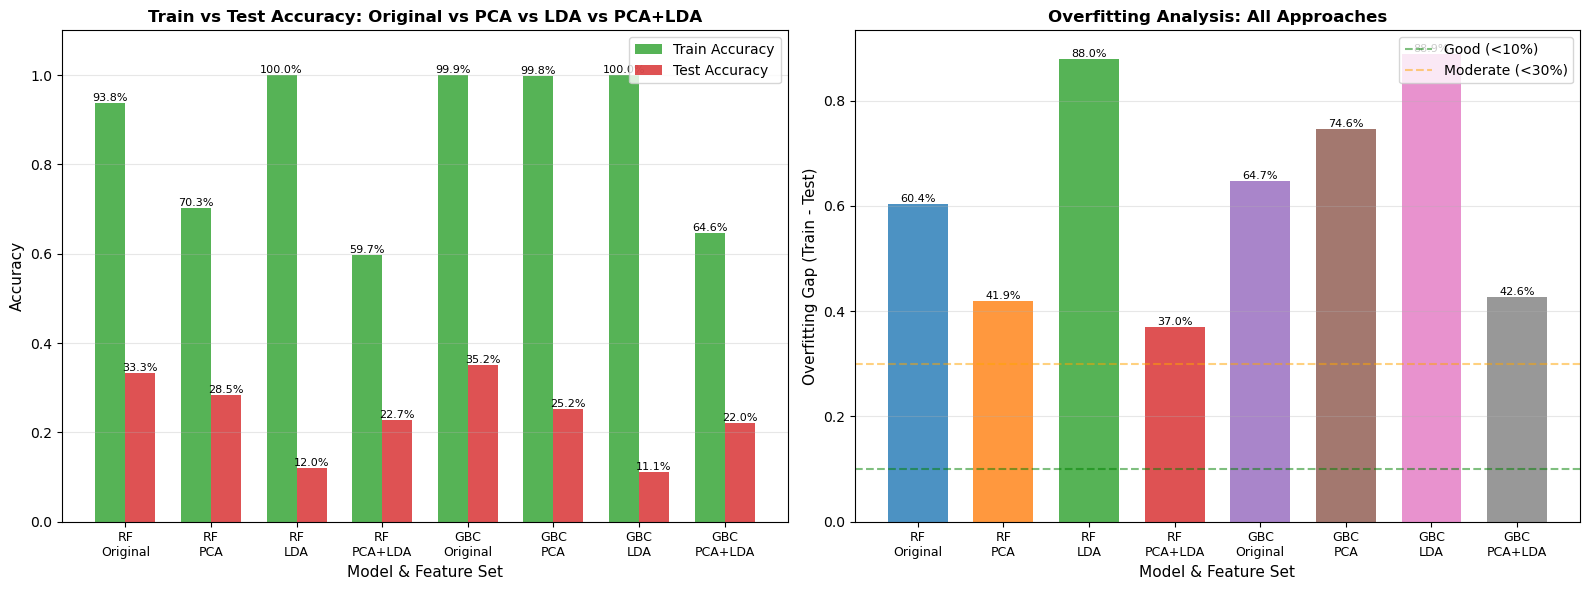

In [53]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = ['RF\nOriginal', 'RF\nPCA', 'RF\nLDA', 'RF\nPCA+LDA', 'GBC\nOriginal', 'GBC\nPCA', 'GBC\nLDA', 'GBC\nPCA+LDA']
train_scores = comparison_df['Train Accuracy'].values
test_scores = comparison_df['Test Accuracy'].values
overfitting_gaps = comparison_df['Overfitting Gap'].values

x = np.arange(len(models))
width = 0.35

# Plot 1: Train vs Test Accuracy Comparison
bars1 = axes[0].bar(x - width/2, train_scores, width, alpha=0.8, label='Train Accuracy', color='#2ca02c')
bars2 = axes[0].bar(x + width/2, test_scores, width, alpha=0.8, label='Test Accuracy', color='#d62728')

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}',
                    ha='center', va='bottom', fontsize=8)

axes[0].set_xlabel('Model & Feature Set', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Train vs Test Accuracy: Original vs PCA vs LDA vs PCA+LDA', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=0, ha='center', fontsize=9)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.1)

# Plot 2: Overfitting Analysis
colors_overfitting = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
bars3 = axes[1].bar(x, overfitting_gaps, width*2, alpha=0.8, color=colors_overfitting)

# Add percentage labels
for bar in bars3:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=8)

axes[1].set_xlabel('Model & Feature Set', fontsize=11)
axes[1].set_ylabel('Overfitting Gap (Train - Test)', fontsize=11)
axes[1].set_title('Overfitting Analysis: All Approaches', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=0, ha='center', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Good (<10%)')
axes[1].axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Moderate (<30%)')
axes[1].legend(loc='upper right')

plt.tight_layout()

# Save plot
import os
os.makedirs('../output/EDA_plots', exist_ok=True)
plt.savefig('../output/EDA_plots/26_dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')

plt.show()